<a href="https://colab.research.google.com/github/CodeineX/Random/blob/main/IE643_Autumn2023_FeedFwdNetDemo_moodle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IE 643: Feed Forward Neural Network Demo**

In this demo, we will see how to build a Multi-layered perceptron (Feed Forward Neural Network or FFNN) using PyTorch.

# Importing the libaries -

In [ ]:
#Import packages related to torch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(1)
torch.manual_seed(1)

# **Loading the Data-**

We will be using MNIST Dataset for the classification problem. MNIST dataset contains grayscale images of handwritten digits of the size 28*28. We will be building a neural network to classify these images.

The MNIST database of handwritten digits, has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.

Source- http://yann.lecun.com/exdb/mnist/

In [ ]:
mnist_train = torchvision.datasets.MNIST('/files/', train=True, download=True,
                                          transform=torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(
                                              (0.1307,), (0.3081,))
                                          ]))

mnist_test = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [ ]:
print(f'Train: X - {mnist_train.data.shape}, y - {mnist_train.targets.shape}')
print(f'Test: X - {mnist_test.data.shape}, y - {mnist_test.targets.shape}')

Train: X - torch.Size([60000, 28, 28]), y - torch.Size([60000])
Test: X - torch.Size([10000, 28, 28]), y - torch.Size([10000])


#### Displaying an image from the dataset

In [ ]:
X_train = mnist_train.data
Y_train = mnist_train.targets

X_test = mnist_test.data
Y_test = mnist_test.targets

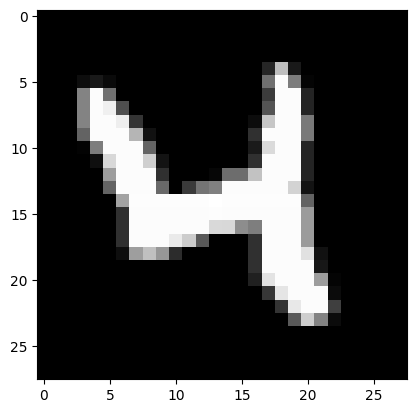



Label in dataset: 4


In [ ]:
plt.imshow(X_train[20],cmap='gray')
plt.show()
print(f"\n\nLabel in dataset: {Y_train[20]}")

In [ ]:
digits = np.unique(Y_train)
print(digits)

[0 1 2 3 4 5 6 7 8 9]


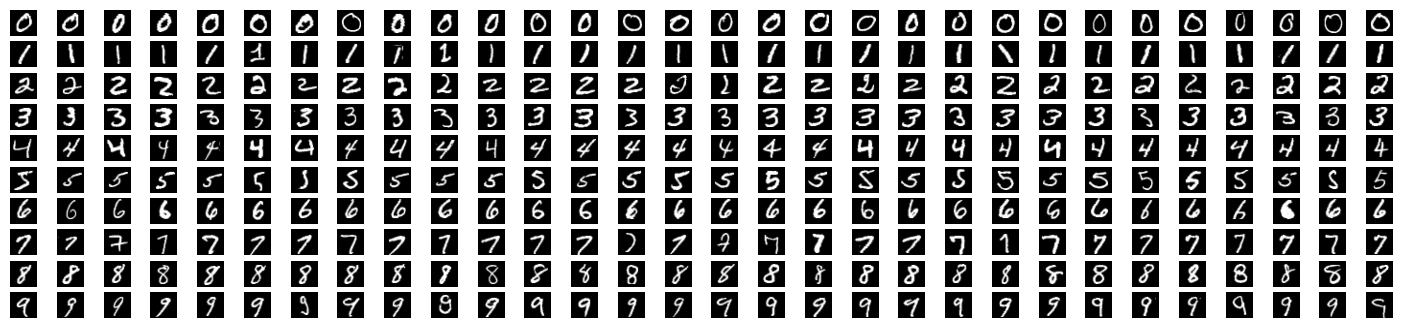

In [ ]:
M = 30 # no of instances for each class
fig, axs = plt.subplots(len(digits), M, figsize=(18,4))
for i,d in enumerate(digits):
    for j in range(M):
        axs[i,j].imshow(X_train[Y_train==d][j], cmap='gray')
        axs[i,j].axis('off')

In [ ]:
#Displaying the contents of 21th image (the choice of index 20 is random here)
X_train[20]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,  38, 190,  25,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,  13,  25,  10,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0, 112, 252, 125,   4,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0, 132, 252, 113,   0,   

As you can see here, each image is a (28x28) 2d numpy array and hence contains 784 individual pixel values (in grayscale).

# **Pre-processing:**

In [ ]:
#displaying the contents of Y_train for 21st image
Y_train[20]

tensor(4)

In [ ]:
#counts for all unique class labels
unique, counts = np.unique(Y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 5923]
 [   1 6742]
 [   2 5958]
 [   3 6131]
 [   4 5842]
 [   5 5421]
 [   6 5918]
 [   7 6265]
 [   8 5851]
 [   9 5949]]


In [ ]:
# flattening single example
example = X_train[40].reshape((-1))
print(type(example))
print("Shape:", example.shape)

<class 'torch.Tensor'>
Shape: torch.Size([784])


# **Pre-processing:**

**Flattening the input values-** Because we are using a simple FFNN, it would be better to convert all the input images of size ${28*28}$ to a size of ${784*1}$ i.e to convert each input from a 2D array to a 1D array.

In [ ]:
# flattening the input

X_train_flattened = X_train.reshape((X_train.shape[0], -1))
X_test_flattened = X_test.reshape((X_test.shape[0], -1))

print(f"Shapes - Train: {X_train_flattened.shape}, Test: {X_test_flattened.shape}")

Shapes - Train: torch.Size([60000, 784]), Test: torch.Size([10000, 784])


**Normalizing input values:**

We often need to normalize the input values into a convinient range. Let us see what is the current range of pixel values:

In [ ]:
print("Minimum pixel value =", X_train_flattened.min())
print("Maximum pixel value =", X_train_flattened.max())

Minimum pixel value = tensor(0, dtype=torch.uint8)
Maximum pixel value = tensor(255, dtype=torch.uint8)


As the pixel values lies between the range 0 and 255, we want to normalize the input such that values of the pixels lies in the range (0,1). So, to normalize, we will divide each input values by the maximum pixel value which in this case is 255.

**Normalizing the dataset:**

In [ ]:
X_normalized_train = np.round(X_train_flattened/X_train_flattened.max(), 3)
X_normalized_test = np.round(X_test_flattened/X_test_flattened.max(), 3)
#print the new values
print("Minimum pixel value =", X_normalized_train.min())
print("Maximum pixel value =", X_normalized_train.max())

Minimum pixel value = tensor(0.)
Maximum pixel value = tensor(1.)


In [ ]:
X_normalized_train[20]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

**Normalized and flattened data can still be visaulized just like original data-**

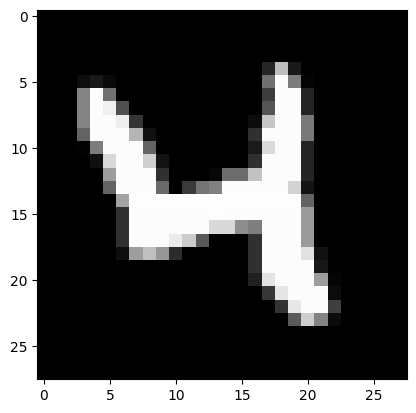

In [ ]:
# normalized and flattened data can still be visualized as original data
plt.imshow(X_normalized_train[20].reshape(28,28), cmap='gray')
plt.show()

In [ ]:
train_idx = np.where((Y_train==2) | (Y_train==4) | (Y_train==6) | (Y_train==8))
X_train_multiclass = X_normalized_train[train_idx]
Y_train_multiclass = Y_train[train_idx]

test_idx = np.where((Y_test==2) | (Y_test==4) | (Y_test==6) | (Y_test==8))
X_test_multiclass = X_normalized_test[test_idx]
Y_test_multiclass = Y_test[test_idx]

print(f'Trainset shapes - X: {X_train_multiclass.shape}, Y: {Y_train_multiclass.shape}')
print(f'Testset shapes - X: {X_test_multiclass.shape}, Y: {Y_test_multiclass.shape}')

print(f'\nTrain statistics - 2: {(Y_train_multiclass==2).sum()}, 4: {(Y_train_multiclass==4).sum()}, 6: {(Y_train_multiclass==6).sum()}, 8: {(Y_train_multiclass==8).sum()}')
print(f'Test statistics - 2: {(Y_test_multiclass==2).sum()}, 4: {(Y_test_multiclass==4).sum()}, 6: {(Y_test_multiclass==6).sum()}, 8: {(Y_test_multiclass==8).sum()}')

Trainset shapes - X: torch.Size([23569, 784]), Y: torch.Size([23569])
Testset shapes - X: torch.Size([3946, 784]), Y: torch.Size([3946])

Train statistics - 2: 5958, 4: 5842, 6: 5918, 8: 5851
Test statistics - 2: 1032, 4: 982, 6: 958, 8: 974





We now have only 2's , 4's , 6's and 8's in the newly created subset of the dataset. As we can see that count of 2's , 4's , 6's and 8's is quite even. So, the dataset is quite evenly balanced.

In [ ]:
# Relabelling for multi class classification

Y_train_multiclass[Y_train_multiclass==2] = 0
Y_test_multiclass[Y_test_multiclass==2] = 0

Y_train_multiclass[Y_train_multiclass==4] = 1
Y_test_multiclass[Y_test_multiclass==4] = 1

Y_train_multiclass[Y_train_multiclass==6] = 2
Y_test_multiclass[Y_test_multiclass==6] = 2

Y_train_multiclass[Y_train_multiclass==8] = 3
Y_test_multiclass[Y_test_multiclass==8] = 3

Often it is observed that training a model for a large number of epochs leads to the model overfitting very much to the training data set. To tackle this issue, we need a validation dataset to keep track of the 'validation performance'. So, we will now split the current training dataset into a training set and validation set.

In general, a split of 90-10, 80-20, 67-33 etc. is used. You can choose your own value as it is always a tradeoff.

We will go with 80-20 split.

In [ ]:
X_train_multiclass, X_val_multiclass, Y_train_multiclass, Y_val_multiclass = train_test_split(X_train_multiclass, Y_train_multiclass, test_size=0.2, random_state = 1)

In [ ]:
print(f'Trainset shapes - X: {X_train_multiclass.shape}, Y: {Y_train_multiclass.shape}')
print(f'Valset shapes - X: {X_val_multiclass.shape}, Y: {Y_val_multiclass.shape}')

print(f'\nTrain statistics - 2: {(Y_train_multiclass==0).sum()}, 4: {(Y_train_multiclass==1).sum()}, 6: {(Y_train_multiclass==2).sum()}, 8: {(Y_train_multiclass==3).sum()}')
print(f'Val statistics - 2: {(Y_val_multiclass==0).sum()}, 4: {(Y_val_multiclass==1).sum()}, 6: {(Y_val_multiclass==2).sum()}, 8: {(Y_val_multiclass==3).sum()}')

Trainset shapes - X: torch.Size([18855, 784]), Y: torch.Size([18855])
Valset shapes - X: torch.Size([4714, 784]), Y: torch.Size([4714])

Train statistics - 2: 4811, 4: 4684, 6: 4676, 8: 4684
Val statistics - 2: 1147, 4: 1158, 6: 1242, 8: 1167


# **Building the Neural Net class:**

![](https://drive.google.com/uc?export=view&id=1XmqNZABFP0ln26aQ6Wokny-79cPRZ3dP)

In [ ]:
input_size = 784
hidden_size_1 = 200
hidden_size_2 = 100
out_size = 4

In [ ]:
class SimpleFeedFwdNet(nn.Module):
    def __init__(self):
        super(SimpleFeedFwdNet, self).__init__()
        # example
        self.hidden1 = nn.Linear(input_size, hidden_size_1)
        self.act1 = nn.Sigmoid()
        nn.init.normal_(self.hidden1.weight)
        self.hidden2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.act2 = nn.Sigmoid()
        nn.init.normal_(self.hidden2.weight)
        self.output = nn.Linear(hidden_size_2, out_size)
        self.act3 = nn.Softmax(dim=1)
        nn.init.normal_(self.output.weight)


    def forward(self, x):
        x = self.hidden1(x)
        x = self.act1(x) #sigmoid activation in first hidden layer
        x = self.hidden2(x)
        x = self.act2(x) #sigmoid activation in second hidden layer
        x = self.output(x)
        #print(x.shape)
        x = self.act3(x) #softmax at last layer
        return x

In [ ]:
def predict_labels(x):
    p = torch.argmax(x, dim=1)
    return p

In [ ]:
def train(model,X_train_multiclass, Y_train_multiclass, batch_size, lr,patience, max_epochs, X_val_multiclass, Y_val_multiclass,verbose = True):

  losses_v = []
  losses_t = []
  counter=0


  train_data = list(zip(X_train_multiclass,Y_train_multiclass))
  validation_data = list(zip(X_val_multiclass,Y_val_multiclass))

  train_loader = DataLoader(train_data, batch_size, shuffle = True)
  # importance of shuffling
  val_loader = DataLoader(validation_data, batch_size, shuffle = False)

  data_size_t = len(train_loader)
  data_size_v = len(val_loader)

  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  CEloss = nn.functional.cross_entropy

  min_loss = np.inf

  for epoch in range(max_epochs):

      total_loss_epoch_t = 0
      total_loss_epoch_v = 0
      model.train()
      for i, (x, y) in enumerate(train_loader):
          # Forward pass
          outputs = model(x)
          # Calculating the loss between predicted and actual output using cross entropy function as the loss function
          loss_t = CEloss(outputs, y)
          train_loss = loss_t.item()
          train_loss = train_loss/data_size_t
          total_loss_epoch_t += train_loss

          # Backward and optimize
          optimizer.zero_grad()
          loss_t.backward()
          optimizer.step()

      model.eval()
      for i, (x, y) in enumerate(val_loader):
          # Forward pass
          outputs = model(x)
          # Calculating the loss between predicted and actual output using cross entropy function as the loss function
          loss_v = CEloss(outputs, y)

          val_loss = loss_v.detach().numpy()
          val_loss = val_loss/data_size_v
          total_loss_epoch_v += val_loss

      losses_v.append(total_loss_epoch_v)
      losses_t.append(total_loss_epoch_t)
      if total_loss_epoch_t < min_loss:
        min_loss = total_loss_epoch_t
        counter = 0
      elif total_loss_epoch_t > (min_loss):
        counter += 1
      if counter >= patience:
        print("Early stopping on",epoch,"th epoch")
        break
          #if (i+1) % 100 == 0:
              #print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{data_size}], Avg Loss: {total_loss_epoch/(i+1):.4f}')


      if epoch == 0 or (epoch+1) % 5 == 0:
        print (f'Epoch [{epoch+1}/{max_epochs}], Avg Tr Loss: {total_loss_epoch_t:.4f}, Avg Val Loss: {total_loss_epoch_v:.4f}')

  if verbose:
      x = np.arange(1, len(losses_t)+1)
      plt.plot(x, losses_t, label="Loss on Train")
      if X_val_multiclass is not None:
          plt.plot(x, losses_v, label="Loss on Val")
      plt.legend()
      plt.title(f"Cross Entropy Loss - Learning Rate = {lr}")
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.show()
  if X_val_multiclass is not None:
      return (losses_t, losses_v)
  return losses_t

**Creating a MLP (Feed forward NN) model instance for our Multi Class Classification :**

Let's now create a simple feed-forward neural network.

* Number of input neurons = 784.


*   Number of hidden layer 1 neurons = 200
*   Number of hidden layer 2 neurons = 100


* Number of output layer neurons = 4.

The number of hidden layers and number of neurons in each hidden layer can be decided by the user.

In [ ]:
model = SimpleFeedFwdNet()
print(model)

SimpleFeedFwdNet(
  (hidden1): Linear(in_features=784, out_features=200, bias=True)
  (act1): Sigmoid()
  (hidden2): Linear(in_features=200, out_features=100, bias=True)
  (act2): Sigmoid()
  (output): Linear(in_features=100, out_features=4, bias=True)
  (act3): Softmax(dim=1)
)


## Training the model:

Epoch [1/500], Avg Tr Loss: 1.4563, Avg Val Loss: 1.4270
Epoch [5/500], Avg Tr Loss: 1.3693, Avg Val Loss: 1.3487
Epoch [10/500], Avg Tr Loss: 1.3217, Avg Val Loss: 1.3042
Epoch [15/500], Avg Tr Loss: 1.2955, Avg Val Loss: 1.2797
Epoch [20/500], Avg Tr Loss: 1.2710, Avg Val Loss: 1.2570
Epoch [25/500], Avg Tr Loss: 1.2163, Avg Val Loss: 1.2042
Epoch [30/500], Avg Tr Loss: 1.1460, Avg Val Loss: 1.1392
Epoch [35/500], Avg Tr Loss: 1.0857, Avg Val Loss: 1.0815
Epoch [40/500], Avg Tr Loss: 1.0306, Avg Val Loss: 1.0303
Epoch [45/500], Avg Tr Loss: 0.9896, Avg Val Loss: 0.9893
Epoch [50/500], Avg Tr Loss: 0.9578, Avg Val Loss: 0.9576
Epoch [55/500], Avg Tr Loss: 0.9325, Avg Val Loss: 0.9331
Epoch [60/500], Avg Tr Loss: 0.9138, Avg Val Loss: 0.9148
Epoch [65/500], Avg Tr Loss: 0.8999, Avg Val Loss: 0.9010
Epoch [70/500], Avg Tr Loss: 0.8886, Avg Val Loss: 0.8900
Epoch [75/500], Avg Tr Loss: 0.8797, Avg Val Loss: 0.8811
Epoch [80/500], Avg Tr Loss: 0.8719, Avg Val Loss: 0.8738
Epoch [85/500], 

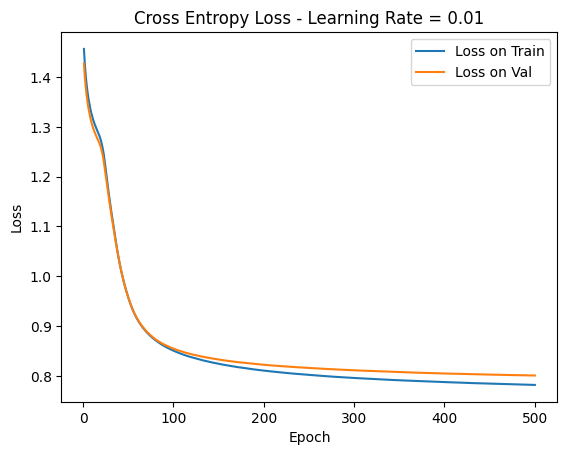

In [ ]:
losses = train(model,X_train_multiclass, Y_train_multiclass, 64, 1e-2, 5, 500, X_val_multiclass, Y_val_multiclass)

In [ ]:
## validatin loss in last 6 epochs
for i in range(6):
  print(f'epoch: {len(losses[1])-i},  val_loss: {losses[1][-i]}')


epoch: 500,  val_loss: 1.4269538618422841
epoch: 499,  val_loss: 0.8009166475888844
epoch: 498,  val_loss: 0.8009487680486731
epoch: 497,  val_loss: 0.8009780009050624
epoch: 496,  val_loss: 0.8010199899609024
epoch: 495,  val_loss: 0.8010562626091209



##Testing the model:
Now it's the time to test our model:

In [ ]:
# checking first 10 predictions
print("First 10 outputs    :", Y_test_multiclass[:10])
output = model.forward(X_test_multiclass[:10])
preds = predict_labels(output)
print("First 10 predictions:", preds)

First 10 outputs    : tensor([0, 1, 1, 2, 1, 2, 2, 1, 1, 1])
First 10 predictions: tensor([0, 1, 1, 2, 1, 2, 2, 1, 1, 2])


Now it's time to check the accuracy of our model on the entire dataset:

In [ ]:
output = model.forward(X_test_multiclass)
#print(output)
Y_pred_multiclass = predict_labels(output)
multiclass_score = sum(torch.eq(Y_pred_multiclass, Y_test_multiclass))/Y_test_multiclass.shape[0]
print("Model accuracy on test data=", round(multiclass_score.item()*100,2),"%")

Model accuracy on test data= 94.78 %


##Confusion matrix:

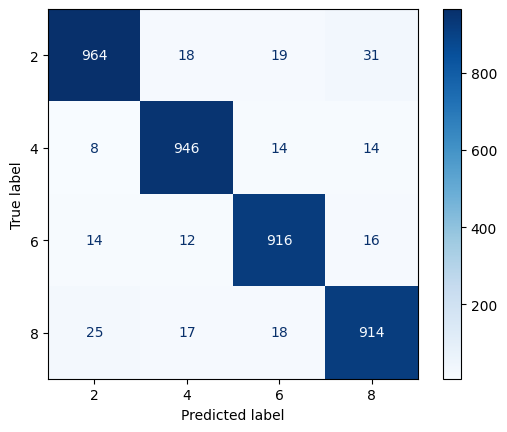


Label totals in dataset:
 [(2, 1032), (4, 982), (6, 958), (8, 974)]


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

matrix_multiclass = confusion_matrix(Y_test_multiclass, Y_pred_multiclass)
ConfusionMatrixDisplay(matrix_multiclass,  display_labels=[2,4,6,8]).plot(cmap="Blues", values_format='')
plt.show()
print("\nLabel totals in dataset:\n", list(zip([2,4,6,8], np.sum(matrix_multiclass, axis=-1))))